In [28]:
import os
import sys

sys.path.append("./")  # Adds higher directory to python modules path.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from data_pipeline import *
import numpy as np
import pandas as pd
from core.ODEDataset import  ODEDataset
from utils import cleaning

In [2]:
print("Available devices:", tf.config.list_physical_devices())
logical_devices = tf.config.list_logical_devices()
print("Active logical devices:", logical_devices)

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Active logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]


Let's load the dataset and  select the columns we want to use as features and labels.

## Constants & Parameters

In [3]:
BATCH_SIZE = 512
EPOCHS = 1000
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0005)
LOSS = tf.keras.losses.BinaryCrossentropy()
PATIENCE = 100
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',    # Metric to monitor (e.g., validation loss)
    patience=PATIENCE,            # Number of epochs to wait for improvement
    restore_best_weights=True,  # Restore weights from the best epoch
    mode='max',

)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_f2_score',  # Metric to monitor
    factor=0.9,          # Reduce learning rate by this factor (50%)
    patience=PATIENCE,          # Wait for 3 epochs of no improvement
    min_lr=1e-6,          # Minimum learning rate
    mode='max'
)

CALLBACKS = [
    EARLY_STOPPING, 
    # reduce_lr
]



In [4]:

Features = [
    #    'Education_level_HHH',
    'Education_level_HHH_Doctoral or equivalent level',
    'Education_level_HHH_Lower secondary education',
    "Education_level_HHH_Master's or equivalent level",
    'Education_level_HHH_No schooling',
    'Education_level_HHH_Not elsewhere classified',
    'Education_level_HHH_Other',
    'Education_level_HHH_Post-secondary non-tertiary education',
    'Education_level_HHH_Primary education',
    'Education_level_HHH_Secondary education',
    'Education_level_HHH_Short-cycle tertiary education',
    'Education_level_HHH_Upper secondary education',
    # 'Socio_status_HHH',
    'Socio_status_HHH_Employee', 'Socio_status_HHH_Employee farm',
    'Socio_status_HHH_Employee non-farm',
    # 'Socio_status_HHH_Employer',
    'Socio_status_HHH_Other', 'Socio_status_HHH_Own-account worker farm',
    'Socio_status_HHH_Own-account worker non-farm',
    'Socio_status_HHH_Unemployed',
    'Socio_status_HHH_Worker not classifiable by status',
    # 'Tariff_payment_frequency',
    'Tariff_payment_frequency_Every 3 months',
    'Tariff_payment_frequency_Every 6 months',
    'Tariff_payment_frequency_Monthly', 'Tariff_payment_frequency_No bill',
    'Tariff_payment_frequency_Other', 'Tariff_payment_frequency_Weekly',

    'HH_with_home_business_Yes',
    'HH_with_home_business_No',
    'HH_with_home_business_missing',

    'Ownership_motorized_vehicle_Yes',
    'Ownership_large_livestock_No',
    'Ownership_motorized_vehicle_missing',

    'Ownership_small_livestock_Yes',
    'Ownership_small_livestock_No',
    'Ownership_small_livestock_missing',

    'Ownership_large_livestock_Yes',
    'Ownership_large_livestock_No',
    'Ownership_large_livestock_missing',

    'Clean_fuel_Yes',
    'Clean_fuel_No',
    'Clean_fuel_missing',

    'Years_of_HHH_in_community',
    'Years_of_HHH_in_community_missing',

    'Dwelling_quality_index',
    'Dwelling_quality_index_missing',

    'Hours_available_electricity',
    'Hours_available_electricity_missing',

    'Measurement_age',
    'Measurement_age_missing',

    'Monthly_expenditure',
    'Monthly_expenditure_missing',

    'Number_of_rooms',
    'Number_of_rooms_missing',
    'Climate_zone_lev_1',
    'Climate_zone_lev_1_missing',

    'Climate_zone_lev_2',
    'Climate_zone_lev_2_missing',

    'Age_HHH',
    'Age_HHH_missing',

    'Number_adults',
    'Number_adults_missing'
]

FEATURE_NUM = len(Features)

THRESHOLD = 0.5

### Metrics

In [5]:
# Custom F2 score metric

def f2_score(y_true, y_pred):
    y_pred = tf.cast(y_pred > THRESHOLD, tf.float32)  # Apply custom threshold
    tp = tf.keras.backend.sum(tf.keras.backend.cast(y_true * y_pred, 'float'), axis=0)  # True Positives
    fp = tf.keras.backend.sum(tf.keras.backend.cast((1 - y_true) * y_pred, 'float'), axis=0)  # False Positives
    fn = tf.keras.backend.sum(tf.keras.backend.cast(y_true * (1 - y_pred), 'float'), axis=0)  # False Negatives
    
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    
    f2 = (5 * precision * recall) / (4 * precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f2)

def precision(y_true, y_pred):
    y_pred = tf.cast(y_pred > THRESHOLD, tf.float32)  # Apply custom threshold
    tp = tf.keras.backend.sum(tf.keras.backend.cast(y_true * y_pred, 'float'), axis=0)  # True Positives
    fp = tf.keras.backend.sum(tf.keras.backend.cast((1 - y_true) * y_pred, 'float'), axis=0)  # False Positives
    
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    return tf.reduce_mean(precision)


def recall(y_true, y_pred):
    y_pred = tf.cast(y_pred > THRESHOLD, tf.float32)  # Apply custom threshold
    tp = tf.keras.backend.sum(tf.keras.backend.cast(y_true * y_pred, 'float'), axis=0)  # True Positives
    fn = tf.keras.backend.sum(tf.keras.backend.cast(y_true * (1 - y_pred), 'float'), axis=0)  # False Negatives

    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    return tf.reduce_mean(recall)


def accuracy(y_true, y_pred):
    y_pred = tf.cast(y_pred > THRESHOLD, tf.float32)  # Apply custom threshold
    tp = tf.keras.backend.sum(tf.keras.backend.cast(y_true * y_pred, 'float'), axis=0)  # True Positives
    tn = tf.keras.backend.sum(tf.keras.backend.cast((1 - y_true) * (1 - y_pred), 'float'), axis=0)  # True Negatives
    fp = tf.keras.backend.sum(tf.keras.backend.cast((1 - y_true) * y_pred, 'float'), axis=0)  # False Positives
    fn = tf.keras.backend.sum(tf.keras.backend.cast(y_true * (1 - y_pred), 'float'), axis=0)  # False Negatives

    accuracy = (tp + tn) / (tp + tn + fp + fn + tf.keras.backend.epsilon())
    return tf.reduce_mean(accuracy)

In [6]:
# OUTPUT =  "Presence_refrigerator/freezer" # {1.0: 0.13849033063006863, 0.0: 0.8615096693699313}
OUTPUT =  "Presence_iron" # {0.0: 0.7690382552735073, 1.0: 0.23096174472649267}
# OUTPUT =  "Presence_fan" # {1.0: 0.25035427491733586, 0.0: 0.7496457250826641}
# OUTPUT =  "Presence_DVD_player" #  {0.0: 0.8856872933396316, 1.0: 0.11431270666036844}
# OUTPUT =  "Presence_radio/stereo" # {1.0: 0.23284005037783376, 0.0: 0.7671599496221663}
# OUTPUT =  "Presence_phone_charger" # {0.0: 0.7842976561219472, 1.0: 0.2157023438780528}
# OUTPUT =  "Presence_TV" # {0.0: 0.8220796266588887, 1.0: 0.17792037334111127}

## Dataset and Feature Selection

In [7]:
path ="./playground/data/dataset_normalized.csv"
dataset = ODEDataset("combined_dataset_cleaned")
dataset.from_csv(path)
dataset = dataset.apply(cleaning.remove_row(OUTPUT, -1))
dataset = add_one_hot_encoding(dataset)
df = dataset.to_dataframe()

In [8]:
features =df[Features]
target = df[OUTPUT]

In [9]:
features.head()

,Education_level_HHH_Doctoral or equivalent level,Education_level_HHH_Lower secondary education,Education_level_HHH_Master's or equivalent level,Education_level_HHH_No schooling,Education_level_HHH_Not elsewhere classified,Education_level_HHH_Other,Education_level_HHH_Post-secondary non-tertiary education,Education_level_HHH_Primary education,Education_level_HHH_Secondary education,Education_level_HHH_Short-cycle tertiary education,...,Number_of_rooms,Number_of_rooms_missing,Climate_zone_lev_1,Climate_zone_lev_1_missing,Climate_zone_lev_2,Climate_zone_lev_2_missing,Age_HHH,Age_HHH_missing,Number_adults,Number_adults_missing
0,False,False,False,False,False,False,False,True,False,False,...,0.086957,0,0.188229,0,0.000000,1,0.0,1,34,0
1,False,False,False,False,False,False,False,True,False,False,...,0.086957,0,0.188229,0,0.000000,1,0.0,1,34,0
10,False,False,False,False,False,False,False,True,False,False,...,0.086957,0,0.188229,0,0.185917,0,0.0,1,44,0
11,False,False,False,False,False,False,False,True,False,False,...,0.086957,0,0.188229,0,0.185917,0,0.0,1,44,0
12,False,False,False,False,False,False,False,True,False,False,...,0.086957,0,0.188229,0,0.185917,0,0.0,1,44,0


In [10]:
x_train_val, x_test, y_train_val, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=42)

### Imbalanced Dataset Handling
We use Imbalanced learning library 
https://imbalanced-learn.org/stable/index.html

In [11]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# sampler = RandomUnderSampler()
sampler = SMOTE(random_state=42)
x_train, y_train = sampler.fit_resample(x_train, y_train )
print(x_train.shape, y_train.shape)

(8604, 60) (8604,)


<Axes: title={'center': 'Training target Distribution'}, ylabel='count'>

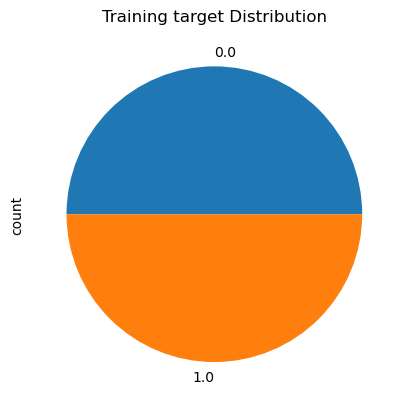

In [12]:
y_train.value_counts().plot(kind='pie', title='Training target Distribution')



<Axes: title={'center': 'Validation target Distribution'}, ylabel='count'>

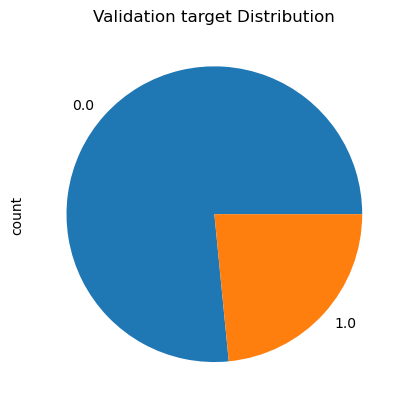

In [13]:
y_val.value_counts().plot(kind='pie', title='Validation target Distribution')

<Axes: title={'center': 'Testing target Distribution'}, ylabel='count'>

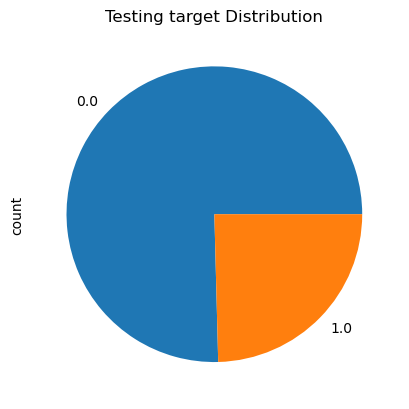

In [14]:
y_test.value_counts().plot(kind='pie', title='Testing target Distribution')

In [15]:
# add min max normalization to the pipeline
def normalize(x, y):
    x = tf.cast(x, tf.float32)
    x = tf.math.divide_no_nan(x - tf.reduce_min(x), tf.reduce_max(x) - tf.reduce_min(x))
    return x, y

In [16]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32).to_numpy(), y_train.astype(np.float32).to_numpy()))
# train_ds = train_ds.map(normalize)
train_ds = train_ds.shuffle(10010).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val.astype(np.float32).to_numpy(), y_val.astype(np.float32).to_numpy()))
# val_ds = val_ds.map(normalize)
val_ds = val_ds.shuffle(10010).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test.astype(np.float32).to_numpy(), y_test.astype(np.float32).to_numpy()))
# test_ds = val_ds.map(normalize)


## Model

In [17]:
def residual_block(input_tensor, units, activation='relu', regularizer=None):
    # First layer in the block
    x = tf.keras.layers.Dense(units, kernel_regularizer=regularizer)(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    # Second layer in the block
    x = tf.keras.layers.Dense(units, kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Skip connection (adding input to output)
    x = tf.keras.layers.Add()([x, input_tensor])
    x = tf.keras.layers.Activation(activation)(x)  # Activation after addition
    
    return x


In [18]:
initializer = tf.keras.initializers.GlorotNormal(2771)  
regularizer = tf.keras.regularizers.l2(0.001)
# Input layer
input_tensor = tf.keras.layers.Input(shape=(FEATURE_NUM,))

units = 4
x = tf.keras.layers.Dense(units,  activation='relu', kernel_regularizer=regularizer)(input_tensor)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Activation('relu')(x)
for i in range(4):    
    x = tf.keras.layers.Dense(units,   kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Activation('relu')(x)
# Output layer
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)


model = tf.keras.Model(inputs=input_tensor, outputs=output)

model.compile(optimizer=OPTIMIZER, loss=LOSS, 
              metrics=[
                        # accuracy,
                        # precision,
                        # recall,
                        # f2_score,
                        tf.keras.metrics.AUC(name='auc'),
                        ])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 dense (Dense)               (None, 4)                 244       
                                                                 
 batch_normalization (BatchN  (None, 4)                16        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 activation (Activation)     (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                             

 batch_normalization_4 (Batc  (None, 4)                16        
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 4)                 0         
                                                                 
 activation_4 (Activation)   (None, 4)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 409
Trainable params: 369
Non-trainable params: 40
_________________________________________________________________


In [19]:
class_weight = {0: 1, 1: 2.0}  # Higher weight for the minority class (1)
history = model.fit(train_ds, epochs=EPOCHS,
                    validation_data=val_ds, 
                    # class_weight=class_weight,
                    callbacks=CALLBACKS
                    )


Epoch 1/1000


17/17 [==============================] - 4s 25ms/step - loss: 0.8282 - auc: 0.5078 - val_loss: 0.7238 - val_auc: 0.4764
Epoch 2/1000
17/17 [==============================] - 0s 8ms/step - loss: 0.8015 - auc: 0.5199 - val_loss: 0.7322 - val_auc: 0.4444
Epoch 3/1000
17/17 [==============================] - 0s 8ms/step - loss: 0.7572 - auc: 0.5552 - val_loss: 0.7385 - val_auc: 0.3728
Epoch 4/1000
17/17 [==============================] - 0s 9ms/step - loss: 0.7386 - auc: 0.5538 - val_loss: 0.7389 - val_auc: 0.4089
Epoch 5/1000
17/17 [==============================] - 0s 9ms/step - loss: 0.7208 - auc: 0.5793 - val_loss: 0.7348 - val_auc: 0.4859
Epoch 6/1000
17/17 [==============================] - 0s 9ms/step - loss: 0.7110 - auc: 0.5964 - val_loss: 0.7272 - val_auc: 0.5638
Epoch 7/1000
17/17 [==============================] - 0s 9ms/step - loss: 0.7043 - auc: 0.6060 - val_loss: 0.7200 - val_auc: 0.6156
Epoch 8/1000
17/17 [==============================] - 0s 9ms/step - loss: 0.6953 - auc: 

## Visualization & Evaluation

Text(0.5, 0, 'Epoch')

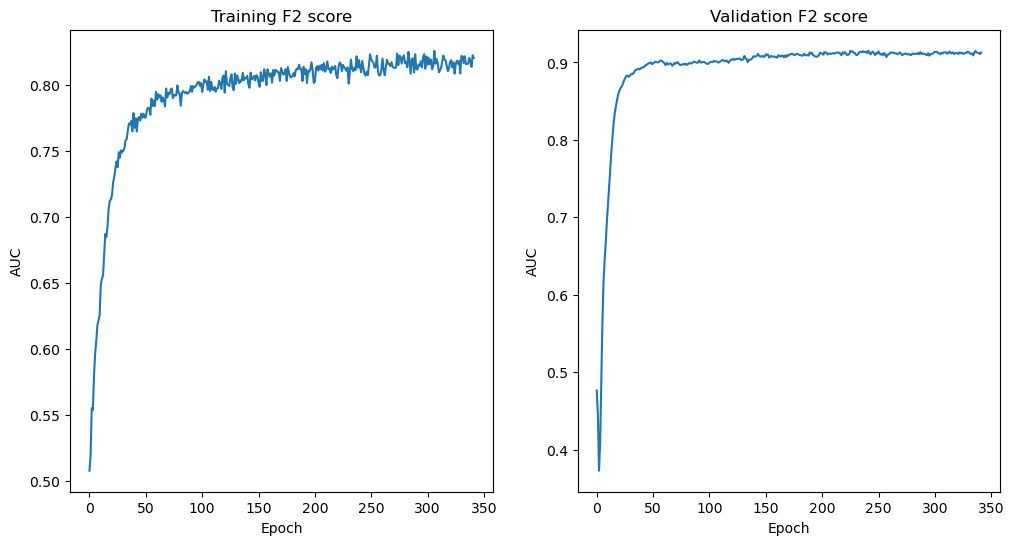

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # (rows, cols, index)
plt.plot(history.history['auc'])
plt.title('Training F2 score')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.subplot(1, 2, 2)
plt.plot(history.history['val_auc'])
plt.title('Validation F2 score')
plt.ylabel('AUC')
plt.xlabel('Epoch')

In [21]:
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)  # (rows, cols, index)
# plt.plot(history.history['precision'])
# plt.title('Training Percision')
# plt.ylabel('Percision')
# plt.xlabel('Epoch')
# plt.subplot(1, 2, 2)
# plt.plot(history.history['val_precision'])
# plt.title('Validation Percision')
# plt.ylabel('Percision')
# plt.xlabel('Epoch')

In [22]:
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)  # (rows, cols, index)
# plt.plot(history.history['recall'])
# plt.title('Training Recall')
# plt.ylabel('Recall')
# plt.xlabel('Epoch')
# plt.subplot(1, 2, 2)
# plt.plot(history.history['val_recall'])
# plt.title('Validation Recall')
# plt.ylabel('Recall')
# plt.xlabel('Epoch')

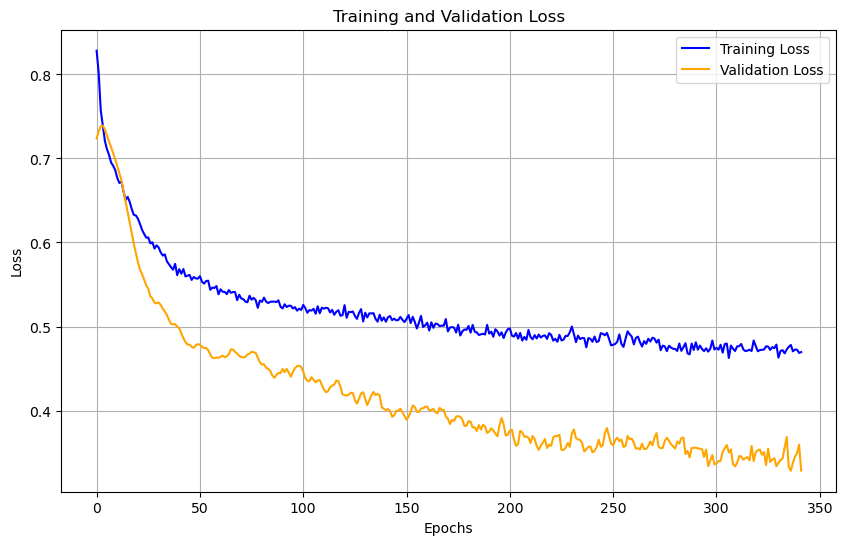

In [23]:


train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue', )
plt.plot(val_loss, label='Validation Loss', color='orange',)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
from sklearn.metrics import classification_report,  precision_score, recall_score, fbeta_score, roc_auc_score

def get_classification_report(x, y_true, threshold=0.5):
 
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred > threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return classification_report(y_true, y_pred)

def get_f2_score(x, y_true, beta = 2, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred > threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return fbeta_score(y_true, y_pred, beta=beta)

def get_precision(x, y_true, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred > threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return precision_score(y_true, y_pred)

def get_recall(x, y_true, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred > threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return recall_score(y_true, y_pred)

def get_auc(x, y_true):
    y_pred = model.predict(x, verbose=0)
    return roc_auc_score(y_true, y_pred)


In [29]:
THRESHOLD = 0.5

x = x_train.astype(np.float32).to_numpy()
y = y_train.astype(np.float32).to_numpy()
fb = get_f2_score(x, y, beta=2, threshold = THRESHOLD, )
pr = get_precision(x, y, THRESHOLD)
re = get_recall(x, y, THRESHOLD)
auc = get_auc(x, y)
print("Training")
print("F2 Score: ", fb)
print("Precision: ", pr)
print("Recall: ", re)
print("AUC: ", auc)
print(get_classification_report(x, y, THRESHOLD))
print("*" * 100)
mask = y_val == 1
one_x_val_masked = x_val[mask]
one_y_val__masked   = y_val[mask]

mask = y_val == 0
zero_x_val_masked = x_val[mask]
zero_y_val__masked   = y_val[mask]


# add one zero to the one mask
on = zero_x_val_masked.sample(one_x_val_masked.shape[0], random_state=42)
zero_x_val_masked = pd.concat([zero_x_val_masked, on])
zero_y_val__masked = pd.concat([zero_y_val__masked, pd.Series([0] * one_x_val_masked.shape[0])])

# add one one to the zero mask
on = one_x_val_masked.sample(zero_x_val_masked.shape[0], random_state=42)
one_x_val_masked = pd.concat([one_x_val_masked, on])
one_y_val__masked = pd.concat([one_y_val__masked, pd.Series([1] * zero_x_val_masked.shape[0])])

x= one_x_val_masked.astype(np.float32).to_numpy()
y = one_y_val__masked.astype(np.float32).to_numpy()
fb = get_f2_score(x, y,  THRESHOLD)
pr = get_precision(x, y, THRESHOLD)
re = get_recall(x, y, THRESHOLD)
# auc = get_auc(x, y)
print("Validation class (1)")
print("F2 Score: ", fb)
print("Precision: ", pr)
print("Recall: ", re)
# print("AUC: ", auc)

print(get_classification_report(x, y, THRESHOLD))
print("*" * 100)

mask = y_val == 0
zero_x_val_masked = x_val[mask]
zero_y_val__masked   = y_val[mask]

x= zero_x_val_masked.astype(np.float32).to_numpy()
y = zero_y_val__masked.astype(np.float32).to_numpy()
fb = get_f2_score(x, y,  THRESHOLD)
pr = get_precision(x, y, THRESHOLD)
re = get_recall(x, y, THRESHOLD)
# auc = get_auc(x, y)
print("Validation class (0)")
print("F2 Score: ", fb)
print("Precision: ", pr)
print("Recall: ", re)
# print("AUC: ", auc)

print(get_classification_report(x, y, THRESHOLD))
print("*" * 100)

Training
F2 Score:  0.9098151688973869
Precision:  0.8400588482555695
Recall:  0.9291027429102743
AUC:  0.9120053196582261
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87      4302
         1.0       0.84      0.93      0.88      4302

    accuracy                           0.88      8604
   macro avg       0.88      0.88      0.88      8604
weighted avg       0.88      0.88      0.88      8604

****************************************************************************************************


ValueError: Cannot take a larger sample than population when 'replace=False'

In [26]:
import shap
import pandas as pd

# Initialize SHAP Explainer (TreeExplainer for tree models, DeepExplainer for deep learning)
explainer = shap.Explainer(model, x_train)
shap_values = explainer(x_train.astype(np.float32).to_numpy())

# Summary Plot: Visualize global feature impact
shap.summary_plot(shap_values, x_train)

# Mean SHAP values (to rank features by importance)
shap_values_mean = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame({
    'feature': x_train.columns,
    'importance': shap_values_mean
}).sort_values(by='importance', ascending=False)
print(feature_importance)

/home/awad/anaconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''